In [217]:
import atoti as tt

In [218]:
session = tt.Session(
    user_content_storage=".content",
    port=9095,
    java_options=["-Xms1G", "-Xmx10G"]
)

Closing existing "Unnamed" session to create the new one.


In [219]:
db_name = "Project1"
db_user = "postgres"
db_password = "postgres"  
db_host = "localhost"  
db_port = "5432"

In [220]:
jdbc_url = f"jdbc:postgresql://{db_host}:{db_port}/{db_name}?user={db_user}&password={db_password}"

In [221]:
jdbc_url

'jdbc:postgresql://localhost:5432/Project1?user=postgres&password=postgres'

In [222]:
facttest = session.read_sql(
    "SELECT * FROM olympics",
    keys=["factid"],
    table_name="factTable",
    url=jdbc_url,
)

In [223]:
facttest.head()

,year,country,bronze,gold,silver,code,depression,schizophrenia,bipolar,eatingdisorder,anxiety
factid,,,,,,,,,,,
5,1992,Bahamas,1,0,0,BHS,527.91235,182.78604,195.25314,60.941833,406.74252
10,1992,Colombia,1,0,0,COL,409.2101,176.92981,160.54938,39.03201,440.6033
27,1992,Japan,16,4,10,JPN,341.07736,194.79625,141.02164,77.96684,257.21765
33,1992,Mexico,0,0,1,MEX,533.24414,180.24562,198.24474,48.886414,274.3233
40,1992,Norway,6,11,10,NOR,508.43967,179.30298,179.03253,89.34628,684.3087


In [224]:
# medals = session.read_sql(
#     "SELECT * FROM medalsnew",
#     keys=["id"],
#     table_name="Medals",
#     url=jdbc_url)

In [225]:
countries = session.read_sql(
    "SELECT * FROM countries",
    keys=["country"],
    table_name="Countries",
    url=jdbc_url)

In [226]:
illness = session.read_sql(
    "SELECT * FROM mentalillness",
    keys=["code","year"],
    table_name="Illness",
    url=jdbc_url)

In [227]:
time = session.read_sql(
    "SELECT * FROM timex",
    keys=["year"],
    table_name="Time",
    url=jdbc_url)

In [228]:
illness.head()

country  depression  schizophrenia    bipolar  eatingdisorder  \
code year                                                                      
AFG  1990  Afghanistan   895.22565      138.24825  147.64412       26.471115   
     1991  Afghanistan   893.88434      137.76122  147.56696       25.548681   
     1999  Afghanistan   896.13806      132.82457  146.76817       19.931143   
ALB  1998      Albania   377.50107      180.97083  117.38581       21.451178   
     2012      Albania    382.8175      184.85753  117.91124       27.027565   

             anxiety  
code year             
AFG  1990     440.33  
     1991  439.47202  
     1999  437.12753  
ALB  1998  353.16174  
     2012  363.28516

In [229]:
facttest.join(countries, facttest["country"] == countries["country"])

In [230]:
facttest.join(illness, (facttest["year"] == illness["year"] )& (facttest["code"] == illness["code"]))

In [231]:
facttest.join(time, facttest["year"] == time["year"])

In [232]:
session.tables.schema

```mermaid
erDiagram
  "Countries" {
    _ String PK "country"
    _ String "continent"
  }
  "Illness" {
    _ String "country"
    _ String PK "code"
    _ int PK "year"
    nullable double "depression"
    nullable double "schizophrenia"
    nullable double "bipolar"
    nullable double "eatingdisorder"
    nullable double "anxiety"
  }
  "Time" {
    _ int PK "year"
  }
  "factTable" {
    _ int PK "factid"
    nullable int "year"
    _ String "country"
    nullable int "bronze"
    nullable int "gold"
    nullable int "silver"
    _ String "code"
    nullable double "depression"
    nullable double "schizophrenia"
    nullable double "bipolar"
    nullable double "eatingdisorder"
    nullable double "anxiety"
  }
  "factTable" }o--o| "Illness" : "(`year` == `year`) & (`code` == `code`)"
  "factTable" }o--o| "Countries" : "`country` == `country`"
  "factTable" }o--o| "Time" : "`year` == `year`"
```


In [233]:
testcube = session.create_cube(facttest)

In [234]:
testcube.measures['total.SUM'] = testcube.measures['gold.SUM'] + testcube.measures['silver.SUM'] + testcube.measures['bronze.SUM']

In [235]:
testcube

In [239]:
hierarchies, levels, measures = testcube.hierarchies, testcube.levels, testcube.measures

In [240]:
print(list(testcube.levels))

[('Time', 'year', 'year'), ('factTable', 'code', 'code'), ('Countries', 'continent', 'continent'), ('Illness', 'country', 'country'), ('factTable', 'factid', 'factid'), ('factTable', 'country', 'country'), ('Countries', 'country', 'country')]


In [156]:
hierarchies

{('Time', 'year'): <atoti.hierarchy.Hierarchy object at 0x7dcfb42b1960>, ('factTable', 'code'): <atoti.hierarchy.Hierarchy object at 0x7dcfb42b1000>, ('Countries', 'continent'): <atoti.hierarchy.Hierarchy object at 0x7dcfb42b1e70>, ('factTable', 'factid'): <atoti.hierarchy.Hierarchy object at 0x7dcfb42b2bc0>, ('factTable', 'country'): <atoti.hierarchy.Hierarchy object at 0x7dcfb42b2f80>}

In [163]:
testcube.levels

In [237]:
testcube.hierarchies["Time", "year"]= [time["year"]]

In [249]:
testcube.query(measures["total.SUM"],measures["depression.SUM"], levels=[levels["Time","year","year"],levels["Countries",'continent','continent']])

total.SUM depression.SUM
year continent                             
1992 Africa               26       6,264.80
     Asia                 52       5,828.14
     Europe              452      15,912.93
     North America        67       3,551.73
     Oceania              43       1,440.25
...                      ...            ...
2016 South America        39       2,047.81
2018 Asia                 14         962.36
     Europe              194      10,864.56
     North America        34         550.24
     Oceania               5       1,452.50

[70 rows x 2 columns]

In [258]:
testcube.query(measures["total.SUM"],measures["depression.MEAN"], levels=[levels["Countries",'country','country']])

,total.SUM,depression.MEAN
country,,
Afghanistan,2,889.02
Algeria,15,737.06
Argentina,36,450.67
Armenia,14,469.99
Australia,347,840.32
...,...,...
Uzbekistan,31,545.10
Venezuela,7,565.55
Vietnam,4,370.13


Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
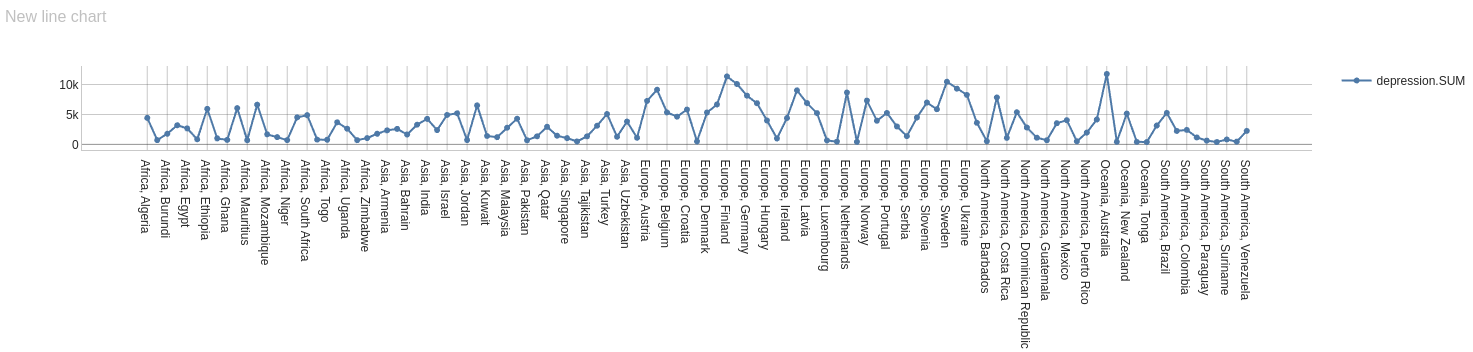

In [250]:
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
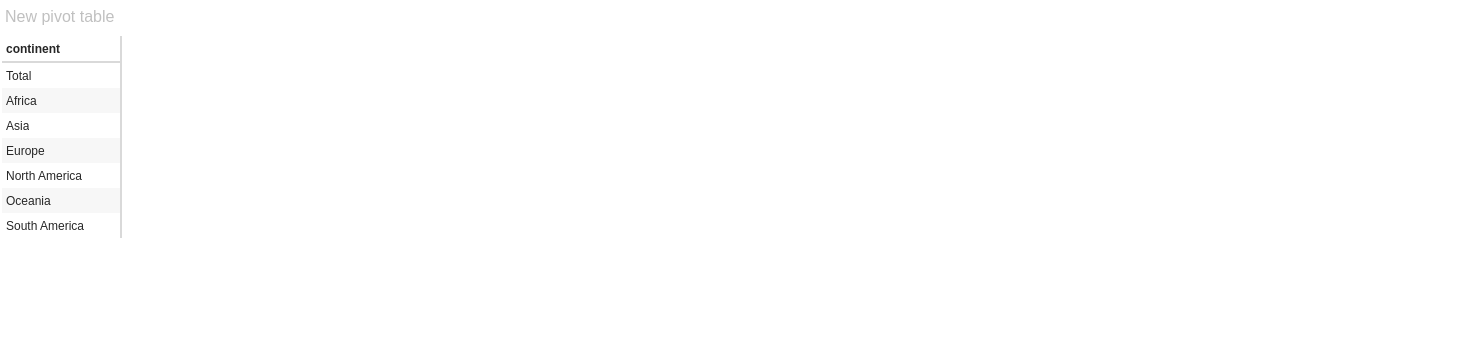

In [251]:
session.widget